In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import logsumexp

## Generate fake data

In [16]:
class FakeDataMaker(object):
    
    def __init__(self, thetas, weights):
        """ theta's are vectors of parameters for the mixture components. weights 
            are the mixture component weights. 
        """
        self.thetas = np.array(thetas)
        self.weights = np.array(weights) / np.sum(weights)
        self.K = len(self.weights)
        
        if len(self.thetas) != self.K:
            raise ValueError("Shape mismatch of thetas and weights")
    
    def generate(self, N, sigma_v=None):
        """ generate random draws from the 'true' model """
        
        comp_ixs = np.random.choice(self.K, p=self.weights, size=N)
        
        true_vs = np.zeros(N)
        for i in range(self.K):
            ix = comp_ixs == i
#             print("Mixture component {}:".format(i))
#             print("\t µ = {}".format(self.thetas[i,0]))
#             print("\t σ = {}".format(self.thetas[i,1]))
#             print("\t {} samples".format(sum(ix)))
             
            true_vs[ix] = np.random.normal(self.thetas[i,0], self.thetas[i,1], size=sum(ix))        
        
        # observe the velocities with known uncertainties
        if sigma_v is None:
            sigma_v = np.random.uniform(15.,20,size=N)
        v = np.random.normal(true_vs, sigma_v)
       
        return v, sigma_v

true_f_triand = 0.4
# true_f_triand = 0.
datamaker = FakeDataMaker(thetas=[[50.,17.], # mean, stddev
                                  [0., 150.]],
                          weights=[true_f_triand, 1-true_f_triand])
vs,sigma_vs = datamaker.generate(N=20)

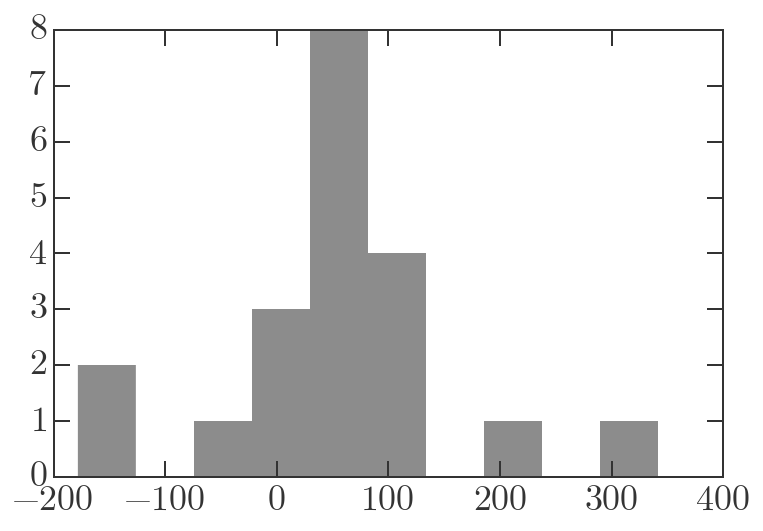

In [17]:
# plt.hist(vs, bins=int(3*np.std(vs)/len(vs)**(1/2.5)));
# n,bins,pa = plt.hist(true_vs, alpha=0.5, bins=int(3*np.std(vs)/len(vs)**(1/2.5)))
plt.hist(vs, alpha=0.5, bins=10);

In [18]:
def ln_likelihood(p, v, sigma_v, datamaker):
    f_triand = p[0]
    
    a = [f_triand, 1-f_triand]
    val = 0.
    for k in range(datamaker.K):
        mu_k = datamaker.thetas[k,0]
        sigma_k = datamaker.thetas[k,1]
        
        pref = a[k] / (2*np.pi*sigma_v*sigma_k)
        var_k = sigma_k**2
        var_n = sigma_v**2
        
        A = (var_k + var_n) / (2*var_n*var_k)
        B = (var_k*v + var_n*mu_k) / (var_n*var_k)
        C = -(var_k*v**2 + var_n*mu_k**2) / (2*var_n*var_k)
        
        val += pref * np.sqrt(np.pi/A) * np.exp(B**2 / (4*A) + C)
    
    ll = np.log(val).sum()
    return ll

def ln_prior(p):
    f_triand = p[0]
    if f_triand < 0 or f_triand > 1.:
        return -np.inf
    
    return 0.

def ln_prob(p, v, sigma_v, datamaker):
    lp = ln_prior(p)
    if np.isinf(lp):
        return -np.inf
    
    ll = ln_likelihood(p, v, sigma_v, datamaker).sum()
    return ll + lp

In [19]:
# should be positive!
ln_likelihood([true_f_triand], vs, sigma_vs, datamaker) - ln_likelihood([0.1], vs, sigma_vs, datamaker)

4.1830977059798613

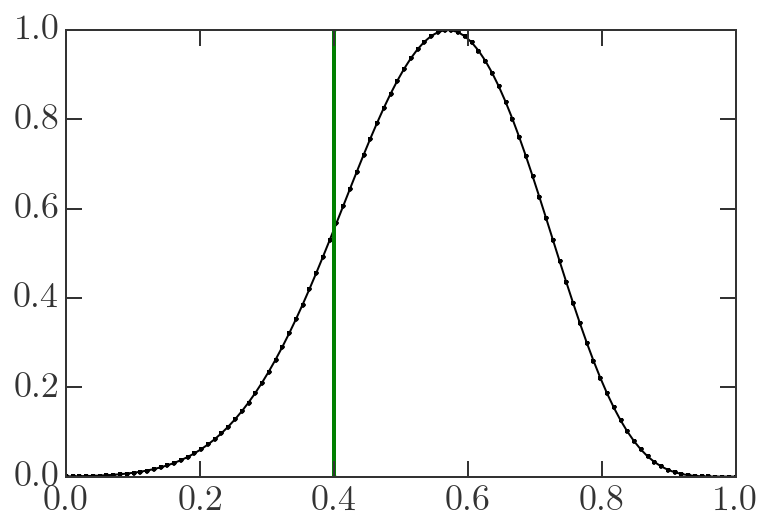

In [20]:
lls = []
fs = np.linspace(0., 1., 100)
for f in fs:
    lls.append(ln_likelihood([f], vs, sigma_vs, datamaker).sum())
lls = np.array(lls)

plt.plot(fs, np.exp(lls-lls.max()), color='k', alpha=1.)
plt.axvline(true_f_triand, color='g', linewidth=2.)

In [21]:
ntrials = 1024
all_lls = []

for i in range(ntrials):
    vs,sigma_vs = datamaker.generate(N=20)
    
    lls = []
    fs = np.linspace(0., 1., 100)
    for f in fs:
        lls.append(ln_likelihood([f], vs, sigma_vs, datamaker).sum())
    lls = np.array(lls)
    all_lls.append(lls)
all_lls = np.array(all_lls)

In [22]:
in_onesigma = []
all_flatchains = []
for i in range(256):    
    vs,sigma_vs = datamaker.generate(N=20)
    
    p0 = np.random.uniform(size=(32,1))
    sampler = emcee.EnsembleSampler(32, 1, ln_prob, args=(vs, sigma_vs, datamaker))
    pos,_,_ = sampler.run_mcmc(p0, 32)
    
#     for chain in sampler.chain:
#         plt.plot(np.arange(-len(chain),0), chain[:,0], marker=None, drawstyle='steps', alpha=0.1)
    
    sampler.reset()
    sampler.run_mcmc(pos, 256)
    
#     for chain in sampler.chain:
#         plt.plot(chain[:,0], marker=None, drawstyle='steps', alpha=0.1)
    all_flatchains.append(sampler.flatchain[:,0].tolist())
    
all_flatchains = np.array(all_flatchains)

In [23]:
in_onesigma = []
in_twosigma = []
for fc in all_flatchains:
    mean_f = np.mean(fc)
    std_f = np.std(fc)
    
    derp = (mean_f - std_f) < true_f_triand < (mean_f + std_f)
    derp2 = (mean_f - 2*std_f) < true_f_triand < (mean_f + 2*std_f)
    in_onesigma.append(derp)
    in_twosigma.append(derp2)
    
in_onesigma = np.array(in_onesigma)
in_twosigma = np.array(in_twosigma)

In [24]:
print(in_onesigma.sum() / float(len(in_onesigma)))
print(in_twosigma.sum() / float(len(in_twosigma)))

0.6875
0.93359375


In [25]:
# bins = np.linspace(0,1,15)
# for fc in all_flatchains[:5]:
#     plt.figure()
#     plt.hist(fc, bins=bins, color='k', alpha=0.5)
#     plt.axvline(true_f_triand, color='g', lw=2.)

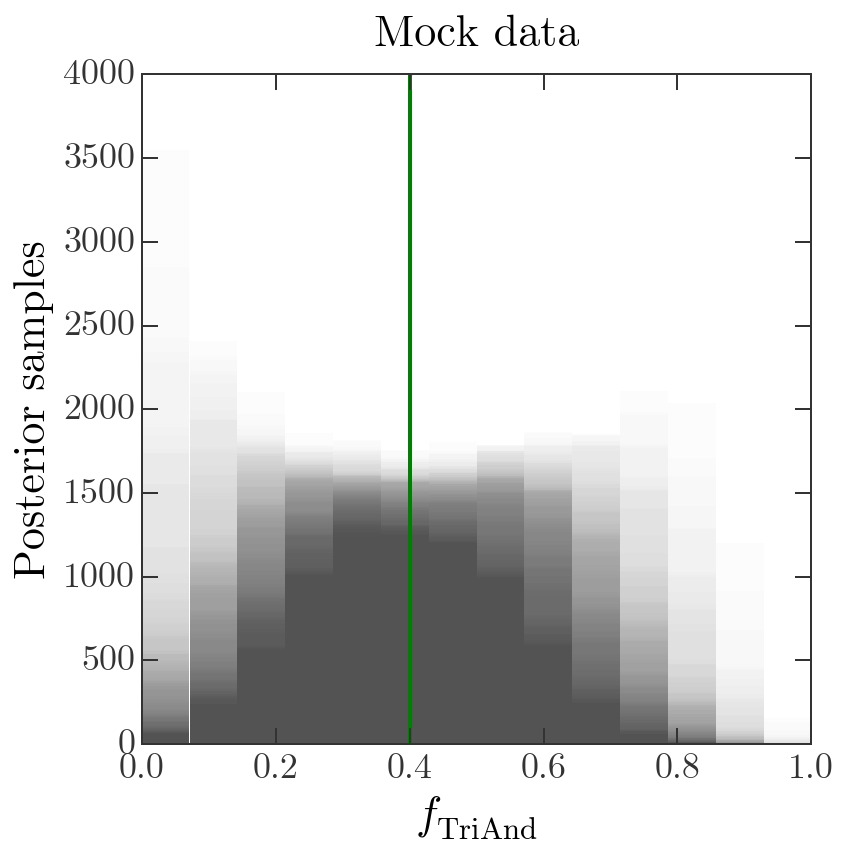

In [28]:
bins = np.linspace(0,1,15)
plt.figure(figsize=(6,6))
for fc in all_flatchains:
    plt.hist(fc, bins=bins, color='k', alpha=0.01)
plt.axvline(true_f_triand, color='g', lw=2., label='truth')
plt.xlabel(r"$f_{\rm TriAnd}$")
plt.ylabel("Posterior samples")
plt.title("Mock data", fontsize=22, y=1.03)

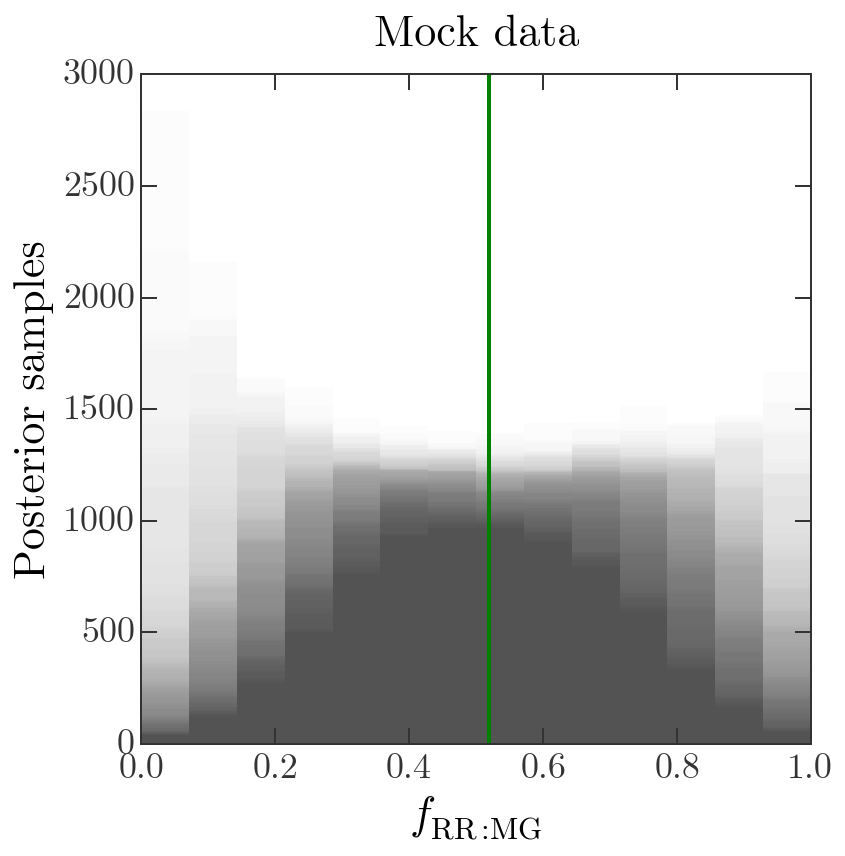

In [35]:
bins = np.linspace(0,1,15)
plt.figure(figsize=(6,6))
for fc in all_flatchains*96/74.:
    plt.hist(fc, bins=bins, color='k', alpha=0.01)
plt.axvline(true_f_triand * 96/74., color='g', lw=2., label='truth')
plt.xlabel(r"$f_{\rm RR:MG}$")
plt.ylabel("Posterior samples")
plt.title("Mock data", fontsize=22, y=1.03)
plt.savefig("/Users/adrian/papers/papers/triand-rrlyrae/figures/mockdata.pdf", bbox_inches='tight')

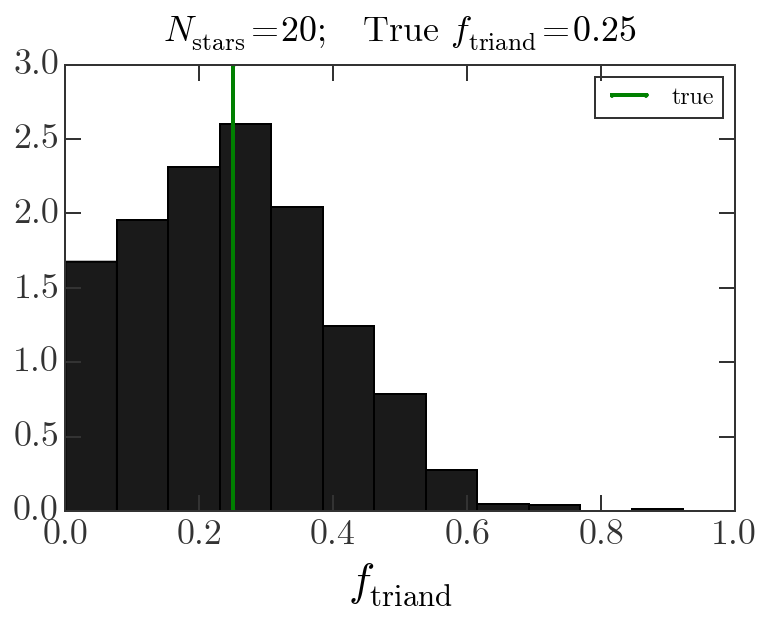

In [132]:
plt.hist(fs[all_lls.argmax(axis=1)], bins=np.linspace(0.,1.,14), edgecolor='k', normed=True)
plt.axvline(true_f_triand, color='g', linewidth=2., label='true')
plt.title(r"$N_{{\rm stars}} = {}$;   True $f_{{\rm triand}} = {}$".format(len(vs), true_f_triand), 
          fontsize=18, y=1.03)
plt.xlabel(r"$f_{\rm triand}$")
plt.legend()